In [30]:
import pandas as pd
import numpy as np
import time
from matplotlib import pyplot as plt
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from memory_profiler import memory_usage

import warnings
warnings.filterwarnings('ignore')


In [31]:
file_path = "/home/yizhen/honours-programme-project/job_datasets/job_data.parquet"
df = pd.read_parquet(file_path)

In [32]:
selected_features = ['node_memory_Percpu_bytes', 
                     'node_context_switches_total', 
                     'surfsara_power_usage', 
                     'node_netstat_Tcp_InSegs', 
                     'node_netstat_Tcp_OutSegs', 
                     'node_network_transmit_packets_total-sum', 
                     'node_filesystem_size_bytes-sum', 
                     'node_filesystem_files-sum', 
                     'node_memory_MemFree_bytes', 
                     'node_netstat_Tcp_InErrs']

In [33]:
# Define time intervals
time_intervals = {'minute': '1T', 'hour': '1H', 'day': '1D'}

# Set sequence length
sequence_length = 30

# Number of time steps to predict into the future
prediction_steps = 7

# Define early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)


In [34]:
# Function to prepare data for LSTM with normalization
def prepare_lstm_data(data, time_interval):
    data.set_index('timestamp', inplace=True)
    data_resampled = data.resample(time_interval).sum()
    
    target_min = data_resampled['target'].min()
    target_max = data_resampled['target'].max()
    data_resampled['target'] = (data_resampled['target'] - target_min) / (target_max - target_min)
    
    return data_resampled


In [35]:
# Function to create sequences for LSTM
def create_lstm_sequences(data, sequence_length):
    sequences, targets = [], []
    for i in range(len(data) - sequence_length):
        seq = data.iloc[i:i+sequence_length].values
        target = data.iloc[i+sequence_length]['target']
        sequences.append(seq)
        targets.append(target)
    return np.array(sequences), np.array(targets)


In [36]:
# Function to make predictions on new data
def predict_future_failures(model, input_data, sequence_length, prediction_steps):
    predictions = []

    for _ in range(prediction_steps):
        # Make a prediction for the next time step
        prediction = model.predict(input_data.reshape(1, sequence_length, input_data.shape[1]))
        predictions.append(prediction[0, 0])

        # Shift the input data by one time step and append the new prediction
        input_data = np.roll(input_data, shift=-1, axis=0)
        input_data[-1, -1] = prediction[0, 0]

    return predictions


# 30 days -> 7 days

In [37]:
# Extract relevant columns
df_selected = df[['timestamp', 'state'] + selected_features].copy()

# Encode the target variable 'state' to binary (0 for "COMPLETED", 1 otherwise)
df_selected['target'] = (df_selected['state'] != 'COMPLETED').astype(int)

# Drop the original 'state' column
df_selected.drop('state', axis=1, inplace=True)

# Normalize selected features
scaler = MinMaxScaler()
df_selected[selected_features] = scaler.fit_transform(df_selected[selected_features])


In [38]:
# Prepare data for LSTM with daily intervals
lstm_data_day = prepare_lstm_data(df_selected, time_intervals['day'])

# Create sequences and targets
sequences_day, targets_day = create_lstm_sequences(lstm_data_day, sequence_length)

# Define the index to split the data
split_index_day = int(len(sequences_day) * 0.7)  # Use 70% of the data for training

# Split the data into training and testing sets
X_train_day, X_test_day = sequences_day[:split_index_day], sequences_day[split_index_day:]
y_train_day, y_test_day = targets_day[:split_index_day], targets_day[split_index_day:]

# Build the LSTM model
lstm_model_day = Sequential()
lstm_model_day.add(LSTM(10, input_shape=(X_train_day.shape[1], X_train_day.shape[2])))
lstm_model_day.add(Dense(1, activation='sigmoid'))
optimizer = Adam(learning_rate=0.0005)
lstm_model_day.compile(loss='mean_squared_error', optimizer=optimizer, metrics=['mean_squared_error'])

# Train the model
history_day = lstm_model_day.fit(X_train_day, y_train_day, epochs=20, batch_size=32, validation_split=0.1)


Epoch 1/20
2/2 [==============================] - 3s 503ms/step - loss: 0.1523 - mean_squared_error: 0.1523 - val_loss: 0.2314 - val_mean_squared_error: 0.2314
Epoch 2/20
2/2 [==============================] - 0s 58ms/step - loss: 0.1476 - mean_squared_error: 0.1476 - val_loss: 0.2297 - val_mean_squared_error: 0.2297
Epoch 3/20
2/2 [==============================] - 0s 53ms/step - loss: 0.1458 - mean_squared_error: 0.1458 - val_loss: 0.2278 - val_mean_squared_error: 0.2278
Epoch 4/20
2/2 [==============================] - 0s 63ms/step - loss: 0.1421 - mean_squared_error: 0.1421 - val_loss: 0.2255 - val_mean_squared_error: 0.2255
Epoch 5/20
2/2 [==============================] - 0s 54ms/step - loss: 0.1418 - mean_squared_error: 0.1418 - val_loss: 0.2231 - val_mean_squared_error: 0.2231
Epoch 6/20
2/2 [==============================] - 0s 53ms/step - loss: 0.1414 - mean_squared_error: 0.1414 - val_loss: 0.2208 - val_mean_squared_error: 0.2208
Epoch 7/20
2/2 [=============================

## Performance_Day

In [39]:
# Evaluate the model using Mean Squared Error
mse_day = lstm_model_day.evaluate(X_test_day, y_test_day, verbose=0)[1]
print(f'Mean Squared Error: {mse_day:.4f}\n')


Mean Squared Error: 0.1232



In [40]:
# Evaluate model on test data
y_pred_day = lstm_model_day.predict(X_test_day)

# Calculate Root Mean Squared Error
rmse_day = mean_squared_error(y_test_day, y_pred_day, squared=False)
print(f'Root Mean Squared Error (RMSE): {rmse_day:.4f}\n')

# Calculate Mean Absolute Error
mae_day = mean_absolute_error(y_test_day, y_pred_day)
print(f'Mean Abosolute Error: {mae_day:.4f}\n')

# Calculate R-squared
r2_day = r2_score(y_test_day, y_pred_day)
print(f'R-squared (R2): {r2_day:.4f}\n')


1/1 [==============================] - 0s 430ms/step
Root Mean Squared Error (RMSE): 0.3510

Mean Abosolute Error: 0.3182

R-squared (R2): -1.1836



### Training and Validation Loss Plot

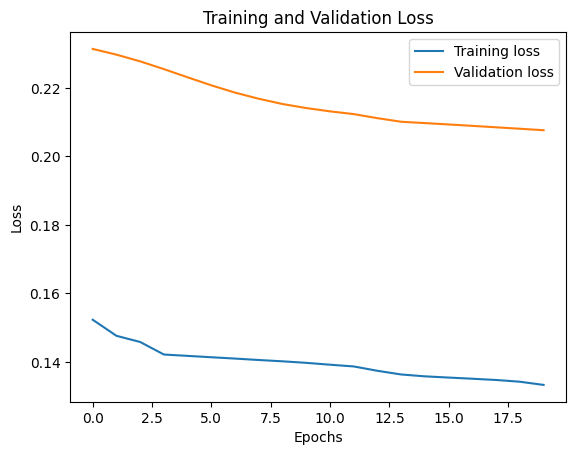

In [41]:
# Plot training and validation loss
plt.plot(history_day.history['loss'], label='Training loss')
plt.plot(history_day.history['val_loss'], label='Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


### Predicted Failures vs. True Failures Plot

1/1 [==============================] - 0s 24ms/step


1/1 [==============================] - 0s 34ms/step
Predicted failures for the next 7 days:
[0.5144648, 0.44822654, 0.44822654, 0.44822654, 0.44822654, 0.44822654, 0.44822648]

Mean Squared Error for Predictions: 0.1385

Mean Absolute Error for Predictions: 0.3604


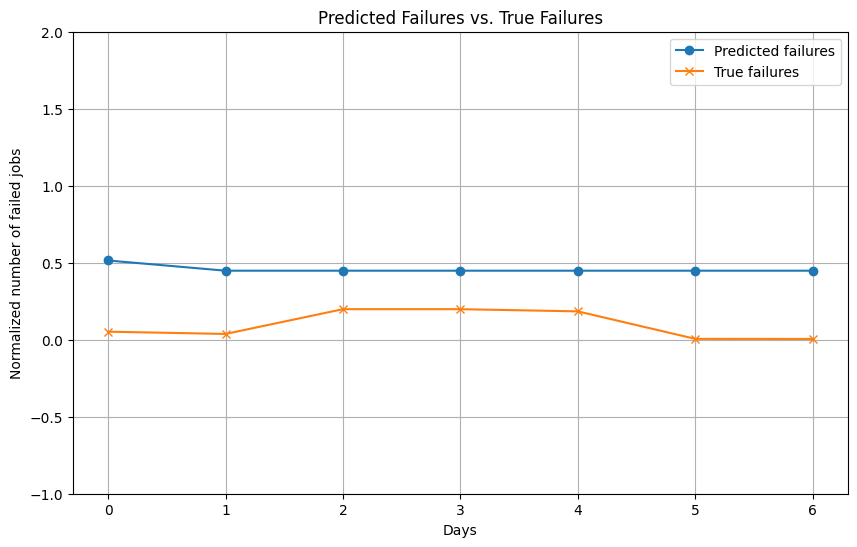

In [42]:
index_day = 10  # Can be any valid starting point

input_data_day = X_test_day[index_day]

# Make predictions
predicted_failures_day = predict_future_failures(lstm_model_day, input_data_day, sequence_length, prediction_steps)

# # Denormalize the predicted failures 
# predicted_failures_denormalized_day = np.array(predicted_failures_day) * (target_max_day - target_min_day) + target_min_day

# Get the true failures for the specified number of days
true_failures_day = y_test_day[index_day:index_day + prediction_steps]

# Print the predicted failures
print("Predicted failures for the next 7 days:")
print(predicted_failures_day)

# Evaluate the predictions using Mean Squared Error
mse_predictions = np.mean((predicted_failures_day - true_failures_day)**2)
print(f'\nMean Squared Error for Predictions: {mse_predictions:.4f}\n')

# Evaluate the predictions using Mean Absolute Error
mae_predictions = np.mean(np.abs(predicted_failures_day - true_failures_day))
print(f'Mean Absolute Error for Predictions: {mae_predictions:.4f}')

# Plot predicted failures vs. true failures
plt.figure(figsize=(10, 6))
plt.plot(predicted_failures_day, label='Predicted failures', marker='o')
plt.plot(true_failures_day, label='True failures', marker='x')
plt.xlabel('Days')
plt.ylabel('Normalized number of failed jobs')
plt.title('Predicted Failures vs. True Failures')
plt.ylim(-1, 2)
plt.legend()
plt.grid(True)
plt.show()


# 30 hours -> 7 hours

In [43]:
# Extract relevant columns
df_selected = df[['timestamp', 'state'] + selected_features].copy()

# Encode the target variable 'state' to binary (0 for "COMPLETED", 1 otherwise)
df_selected['target'] = (df_selected['state'] != 'COMPLETED').astype(int)

# Drop the original 'state' column
df_selected.drop('state', axis=1, inplace=True)

# Normalize selected features
scaler = MinMaxScaler()
df_selected[selected_features] = scaler.fit_transform(df_selected[selected_features])


In [44]:
# Prepare data for LSTM with hourly intervals
lstm_data_hour = prepare_lstm_data(df_selected, time_intervals['hour'])

# Create sequences and targets
sequences_hour, targets_hour = create_lstm_sequences(lstm_data_hour, sequence_length)

# Define the index to split the data
split_index_hour = int(len(sequences_hour) * 0.7)  # Use 70% of the data for training

# Split the data into training and testing sets
X_train_hour, X_test_hour = sequences_hour[:split_index_hour], sequences_hour[split_index_hour:]
y_train_hour, y_test_hour = targets_hour[:split_index_hour], targets_hour[split_index_hour:]

# Build the LSTM model
lstm_model_hour = Sequential()
lstm_model_hour.add(LSTM(20, input_shape=(X_train_hour.shape[1], X_train_hour.shape[2])))
lstm_model_hour.add(Dense(1, activation='sigmoid'))
lstm_model_hour.compile(loss='mean_squared_error', optimizer='adam', metrics=['mean_squared_error'])

# Train the model
history_hour = lstm_model_hour.fit(X_train_hour, y_train_hour, epochs=20, batch_size=32, validation_split=0.1, callbacks=[early_stopping])


Epoch 1/20
54/54 [==============================] - 4s 27ms/step - loss: 0.0759 - mean_squared_error: 0.0759 - val_loss: 0.0339 - val_mean_squared_error: 0.0339
Epoch 2/20
54/54 [==============================] - 1s 17ms/step - loss: 0.0046 - mean_squared_error: 0.0046 - val_loss: 0.0087 - val_mean_squared_error: 0.0087
Epoch 3/20
54/54 [==============================] - 1s 17ms/step - loss: 0.0014 - mean_squared_error: 0.0014 - val_loss: 0.0021 - val_mean_squared_error: 0.0021
Epoch 4/20
54/54 [==============================] - 1s 18ms/step - loss: 4.5297e-04 - mean_squared_error: 4.5297e-04 - val_loss: 0.0015 - val_mean_squared_error: 0.0015
Epoch 5/20
54/54 [==============================] - 1s 18ms/step - loss: 3.6763e-04 - mean_squared_error: 3.6763e-04 - val_loss: 0.0014 - val_mean_squared_error: 0.0014
Epoch 6/20
54/54 [==============================] - 1s 18ms/step - loss: 3.4694e-04 - mean_squared_error: 3.4694e-04 - val_loss: 0.0014 - val_mean_squared_error: 0.0014
Epoch 7/20

## Performance_Hour

In [45]:
# Evaluate the model using Mean Squared Error
mse_hour = lstm_model_hour.evaluate(X_test_hour, y_test_hour, verbose=0)[1]
print(f'Mean Squared Error: {mse_hour:.4f}\n')


Mean Squared Error: 0.0053



In [46]:
# Evaluate model on test data
y_pred_hour = lstm_model_hour.predict(X_test_hour)

# Calculate Root Mean Squared Error
rmse_hour = mean_squared_error(y_test_hour, y_pred_hour, squared=False)
print(f'Root Mean Squared Error (RMSE): {rmse_hour:.4f}\n')

# Calculate Mean Absolute Error
mae_hour = mean_absolute_error(y_test_hour, y_pred_hour)
print(f'Mean Abosolute Error: {mae_hour:.4f}\n')

# Calculate R-squared
r2_hour = r2_score(y_test_hour, y_pred_hour)
print(f'R-squared (R2): {r2_hour:.4f}\n')


26/26 [==============================] - 1s 6ms/step
Root Mean Squared Error (RMSE): 0.0727

Mean Abosolute Error: 0.0252

R-squared (R2): -0.0033



### Training and Validation Loss Plot

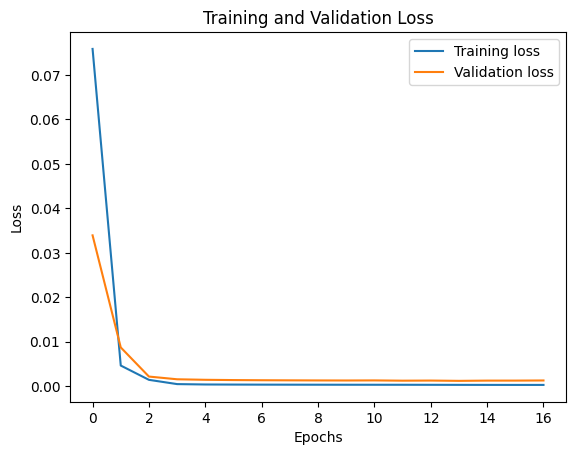

In [47]:
# Plot training and validation loss
plt.plot(history_hour.history['loss'], label='Training loss')
plt.plot(history_hour.history['val_loss'], label='Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


### Predicted Failures vs. True Failures Plot

1/1 [==============================] - 0s 22ms/step
Predicted failures for the next 7 hours:
[0.008725264, 0.009622413, 0.009701679, 0.013534485, 0.013552789, 0.01349521, 0.013474835]

Mean Squared Error for Predictions: 0.0004

Mean Absolute Error for Predictions: 0.0195


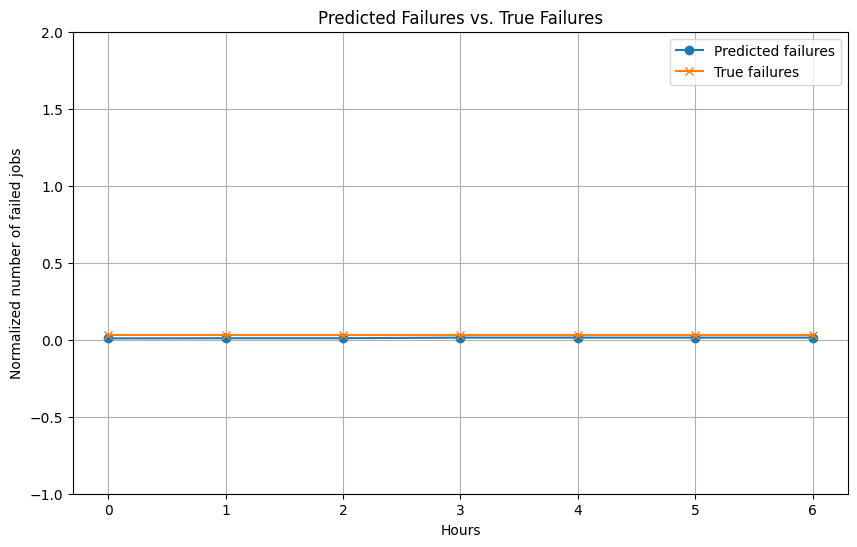

In [48]:
index_hour = 500  # Can be any valid starting point

input_data_hour = X_test_hour[index_hour]

# Make predictions
predicted_failures_hour = predict_future_failures(lstm_model_hour, input_data_hour, sequence_length, prediction_steps)

# # Denormalize the predicted failures 
# predicted_failures_denormalized_hour = np.array(predicted_failures_hour) * (target_max_hour - target_min_hour) + target_min_hour

# Get the true failures for the specified number of hours
true_failures_hour = y_test_hour[index_hour:index_hour + prediction_steps] 

# Print the predicted failures
print("Predicted failures for the next 7 hours:")
print(predicted_failures_hour)

# Evaluate the predictions using Mean Squared Error
mse_predictions = np.mean((predicted_failures_hour - true_failures_hour)**2)
print(f'\nMean Squared Error for Predictions: {mse_predictions:.4f}\n')

# Evaluate the predictions using Mean Absolute Error
mae_predictions = np.mean(np.abs(predicted_failures_hour - true_failures_hour))
print(f'Mean Absolute Error for Predictions: {mae_predictions:.4f}')

# Plot predicted failures vs. true failures
plt.figure(figsize=(10, 6))
plt.plot(predicted_failures_hour, label='Predicted failures', marker='o')
plt.plot(true_failures_hour, label='True failures', marker='x')
plt.xlabel('Hours')
plt.ylabel('Normalized number of failed jobs')
plt.title('Predicted Failures vs. True Failures')
plt.legend()
plt.ylim(-1, 2)
plt.grid(True)
plt.show()


# 30 minutes -> 7 minutes

In [49]:
# Extract relevant columns
df_selected = df[['timestamp', 'state'] + selected_features].copy()

# Encode the target variable 'state' to binary (0 for "COMPLETED", 1 otherwise)
df_selected['target'] = (df_selected['state'] != 'COMPLETED').astype(int)

# Drop the original 'state' column
df_selected.drop('state', axis=1, inplace=True)

# Normalize selected features
scaler = MinMaxScaler()
df_selected[selected_features] = scaler.fit_transform(df_selected[selected_features])


In [50]:
# Prepare data for LSTM with minute intervals
lstm_data_min = prepare_lstm_data(df_selected, time_intervals['minute'])

# Create sequences and targets
sequences_min, targets_min = create_lstm_sequences(lstm_data_min, sequence_length)

# Define the index to split the data
split_index_min = int(len(sequences_min) * 0.7)  # Use 70% of the data for training

# Split the data into training and testing sets
X_train_min, X_test_min = sequences_min[:split_index_min], sequences_min[split_index_min:]
y_train_min, y_test_min = targets_min[:split_index_min], targets_min[split_index_min:]

# Build the LSTM model
lstm_model_min = Sequential()

# 50 -> 10
lstm_model_min.add(LSTM(2, input_shape=(X_train_min.shape[1], X_train_min.shape[2])))
lstm_model_min.add(Dense(1, activation='sigmoid'))
lstm_model_min.compile(loss='mean_squared_error', optimizer='adam', metrics=['mean_squared_error'])

# Train the model
history_min = lstm_model_min.fit(X_train_min, y_train_min, epochs=5, batch_size=32, validation_split=0.1, callbacks=[early_stopping])


Epoch 1/5
3258/3258 [==============================] - 54s 16ms/step - loss: 0.0218 - mean_squared_error: 0.0218 - val_loss: 0.0016 - val_mean_squared_error: 0.0016
Epoch 2/5
3258/3258 [==============================] - 51s 16ms/step - loss: 6.9106e-04 - mean_squared_error: 6.9106e-04 - val_loss: 4.2866e-04 - val_mean_squared_error: 4.2866e-04
Epoch 3/5
3258/3258 [==============================] - 55s 17ms/step - loss: 5.3392e-04 - mean_squared_error: 5.3392e-04 - val_loss: 3.0812e-04 - val_mean_squared_error: 3.0812e-04
Epoch 4/5
3258/3258 [==============================] - 56s 17ms/step - loss: 5.2523e-04 - mean_squared_error: 5.2523e-04 - val_loss: 3.0617e-04 - val_mean_squared_error: 3.0617e-04
Epoch 5/5
3258/3258 [==============================] - 57s 17ms/step - loss: 5.2241e-04 - mean_squared_error: 5.2241e-04 - val_loss: 3.0853e-04 - val_mean_squared_error: 3.0853e-04


## Performance_Minute

In [51]:
# Evaluate the model using Mean Squared Error
mse_min = lstm_model_min.evaluate(X_test_min, y_test_min, verbose=0)[1]
print(f'Mean Squared Error: {mse_min:.4f}\n')


Mean Squared Error: 0.0050



In [52]:
# Evaluate model on test data
y_pred_min = lstm_model_min .predict(X_test_min )

# Calculate Root Mean Squared Error
rmse_min = mean_squared_error(y_test_min, y_pred_min, squared=False)
print(f'Root Mean Squared Error (RMSE): {rmse_min:.4f}\n')

# Calculate Mean Absolute Error
mae_min = mean_absolute_error(y_test_min, y_pred_min)
print(f'Mean Absolute Error: {mae_min:.4f}\n')

# Calculate R-squared
r2_min = r2_score(y_test_min, y_pred_min)
print(f'R-squared (R2): {r2_min:.4f}\n')


1552/1552 [==============================] - 9s 5ms/step
Root Mean Squared Error (RMSE): 0.0704

Mean Absolute Error: 0.0303

R-squared (R2): 0.0699



### Training and Validation Loss Plot

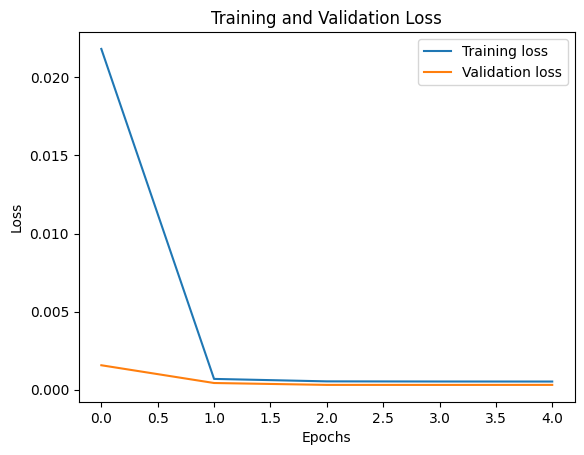

In [53]:
# Plot training and validation loss
plt.plot(history_min.history['loss'], label='Training loss')
plt.plot(history_min.history['val_loss'], label='Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


### Predicted Failures vs. True Failures Plot

1/1 [==============================] - 0s 21ms/step
Predicted failures for the next 7 minutes:
[0.017582493, 0.017582484, 0.017582484, 0.017582484, 0.017582484, 0.017582484, 0.017582484]

Mean Squared Error for Predictions: 0.0003

Mean Absolute Error for Predictions: 0.0176


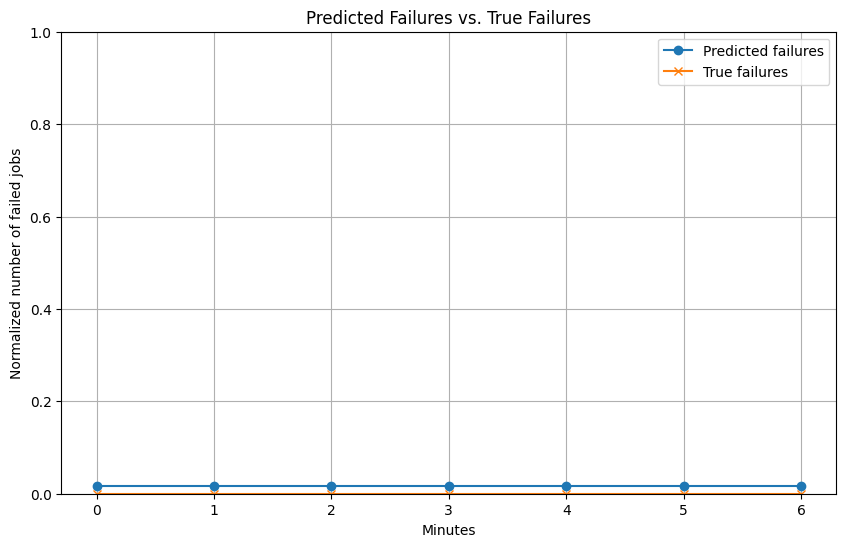

In [54]:
index_min = 0  # Can be any valid starting point

input_data_min = X_test_min[index_min]

# Make predictions
predicted_failures_min = predict_future_failures(lstm_model_min, input_data_min, sequence_length, prediction_steps)

# # Denormalize the predicted failures 
# predicted_failures_denormalized_min = np.array(predicted_failures_min) * (target_max_min- target_min_min) + target_min_min

# Get the true failures for the specified number of minutes
true_failures_min = y_test_min[index_min:index_min + prediction_steps]

# Print the predicted failures
print("Predicted failures for the next 7 minutes:")
print(predicted_failures_min)

# Evaluate the predictions using Mean Squared Error
mse_predictions = np.mean((predicted_failures_min - true_failures_min)**2)
print(f'\nMean Squared Error for Predictions: {mse_predictions:.4f}\n')

# Evaluate the predictions using Mean Absolute Error
mae_predictions = np.mean(np.abs(predicted_failures_min - true_failures_min))
print(f'Mean Absolute Error for Predictions: {mae_predictions:.4f}')

# Plot predicted failures vs. true failures
plt.figure(figsize=(10, 6))
plt.plot(predicted_failures_min, label='Predicted failures', marker='o')
plt.plot(true_failures_min, label='True failures', marker='x')
plt.xlabel('Minutes')
plt.ylabel('Normalized number of failed jobs')
plt.title('Predicted Failures vs. True Failures')
plt.legend()
plt.ylim(0, 1)
plt.grid(True)
plt.show()


# Model Comparison

## Attention Visualization

## Scalability and Efficiency Analysis 
### Time and Memory Complexity Analysis

In [55]:
# Define a function to profile memory usage
def profile_memory(func):
    mem_usage = memory_usage((func, ()))
    return max(mem_usage)


In [56]:
# Measure inference time for the LSTM model
start_time_day = time.time()
lstm_model_day.predict(X_test_day)
end_time_day = time.time()
inference_time_lstm_day = end_time_day - start_time_day
print("LSTM model inference time (Day):", inference_time_lstm_day, "seconds")

start_time_hour = time.time()
lstm_model_hour.predict(X_test_hour)
end_time_hour = time.time()
inference_time_lstm_hour = end_time_hour - start_time_hour
print("LSTM model inference time (Hour):", inference_time_lstm_hour, "seconds")

start_time_minute = time.time()
lstm_model_min.predict(X_test_min)
end_time_minute = time.time()
inference_time_lstm_minute = end_time_minute - start_time_minute
print("LSTM model inference time (Minute):", inference_time_lstm_minute, "seconds")

# Measure memory usage during model inference
memory_usage_day = profile_memory(lambda: lstm_model_day.predict(X_test_day))
print("LSTM model memory usage (Day):", memory_usage_day, "bytes")

memory_usage_hour = profile_memory(lambda: lstm_model_hour.predict(X_test_hour))
print("LSTM model memory usage (Hour):", memory_usage_hour, "bytes")

memory_usage_minute = profile_memory(lambda: lstm_model_min.predict(X_test_min))
print("LSTM model memory usage (Minute):", memory_usage_minute, "bytes")


1/1 [==============================] - 0s 23ms/step
LSTM model inference time (Day): 0.06832051277160645 seconds
 1/26 [>.............................] - ETA: 0s

26/26 [==============================] - 0s 6ms/step
LSTM model inference time (Hour): 0.24533820152282715 seconds
1552/1552 [==============================] - 8s 5ms/step
LSTM model inference time (Minute): 8.899914026260376 seconds
1/1 [==============================] - 0s 46ms/step
LSTM model memory usage (Day): 2704.30078125 bytes
26/26 [==============================] - 0s 8ms/step
LSTM model memory usage (Hour): 2705.48046875 bytes
1552/1552 [==============================] - 8s 5ms/step
LSTM model memory usage (Minute): 2770.1953125 bytes
